In [1]:
import pandas as pd 
from subs.energy_api import *
import urllib3

# Suppress only the single InsecureRequestWarning from urllib3 needed for bypassing SSL verification
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

df_carbon_forecast_indexed =carbon_api_forecast()


In [2]:
df_carbon_forecast_indexed

,FieldName,Region,Value
EffectiveTime,,,
2024-02-17 20:00:00,CO2_INTENSITY_FORECAST,ALL,200.9168
2024-02-17 20:30:00,CO2_INTENSITY_FORECAST,ALL,207.9352
2024-02-17 21:00:00,CO2_INTENSITY_FORECAST,ALL,211.3738
2024-02-17 21:30:00,CO2_INTENSITY_FORECAST,ALL,211.9682
2024-02-17 22:00:00,CO2_INTENSITY_FORECAST,ALL,208.3744
2024-02-17 22:30:00,CO2_INTENSITY_FORECAST,ALL,210.2571
2024-02-17 23:00:00,CO2_INTENSITY_FORECAST,ALL,215.8810
2024-02-17 23:30:00,CO2_INTENSITY_FORECAST,ALL,217.5741


In [5]:
co2_stats_prior_day, df_carbon_intensity_recent = carbon_api_intensity()

/Users/saeed/Documents/GitHub/telegram-energy-api/subs/energy_api.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
df_carbon_intensity_recent

,FieldName,Region,Value
EffectiveTime,,,
2024-02-16 20:00:00,CO2_INTENSITY,ALL,272.0
2024-02-16 20:15:00,CO2_INTENSITY,ALL,263.0
2024-02-16 20:30:00,CO2_INTENSITY,ALL,264.0
2024-02-16 20:45:00,CO2_INTENSITY,ALL,255.0
2024-02-16 21:00:00,CO2_INTENSITY,ALL,260.0
...,...,...,...
2024-02-17 18:45:00,CO2_INTENSITY,ALL,199.0
2024-02-17 19:00:00,CO2_INTENSITY,ALL,202.0
2024-02-17 19:15:00,CO2_INTENSITY,ALL,200.0


In [7]:
co2_stats_prior_day

{'mean': 216.80208333333334, 'min': 169.0, 'max': 272.0}

In [9]:
df_ = status_classification(df_carbon_forecast_indexed,co2_stats_prior_day)

In [72]:
df = df_.copy()

In [34]:
df

,FieldName,Region,Value,status_compared_to_yesterday,status_compared_to_EU
EffectiveTime,,,,,
2024-02-17 20:00:00,CO2_INTENSITY_FORECAST,ALL,200.9168,medium,low
2024-02-17 20:30:00,CO2_INTENSITY_FORECAST,ALL,207.9352,medium,low
2024-02-17 21:00:00,CO2_INTENSITY_FORECAST,ALL,211.3738,medium,low
2024-02-17 21:30:00,CO2_INTENSITY_FORECAST,ALL,211.9682,medium,low
2024-02-17 22:00:00,CO2_INTENSITY_FORECAST,ALL,208.3744,medium,low
2024-02-17 22:30:00,CO2_INTENSITY_FORECAST,ALL,210.2571,medium,low
2024-02-17 23:00:00,CO2_INTENSITY_FORECAST,ALL,215.8810,medium,low
2024-02-17 23:30:00,CO2_INTENSITY_FORECAST,ALL,217.5741,medium,low


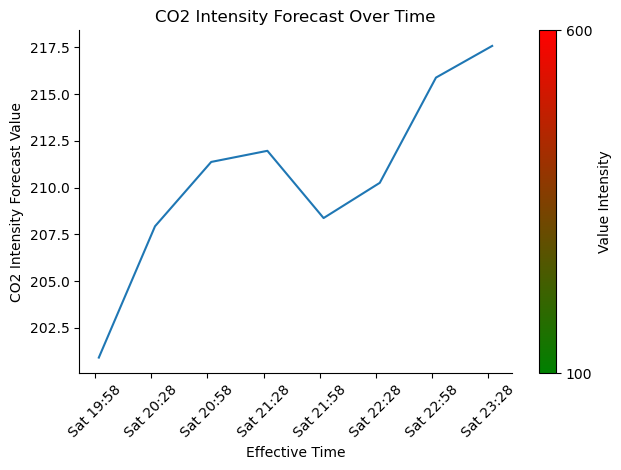

In [33]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Setting the colormap (cmap) range
norm = plt.Normalize(100, 600)

# Create a custom colormap from green to red
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_green_red", ["green", "red"]
)
# Creating the plot
fig, ax = plt.subplots()
# sc = ax.scatter(df.index, df['Value'], c=df['Value'], cmap=cmap, norm=norm)

sc = plt.plot(df.index, df['Value'])

# # Creating a colorbar based on the colormap
# cbar = plt.colorbar(sc)
# cbar.set_label('CO2 Intensity')

# Adjusting the x-axis to show every 30 minutes
ax.xaxis_date()  # Ensure we're working with dates on the x-axis
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # Changed to show every 30 minutes
ax.xaxis.set_major_formatter(mdates.DateFormatter("%a %H:%M"))  # Day name and HH:MM



# Create and customize the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", label="Value Intensity")
cbar.set_ticks([norm.vmin, norm.vmax])  # Set ticks to the min and max of the data
cbar.set_ticklabels(
    [100, 600], color="black"
)  # Format min and max values as labels

plt.xticks(rotation=45)
plt.xlabel('Effective Time')
plt.ylabel('CO2 Intensity Forecast Value')
plt.title('CO2 Intensity Forecast Over Time')


# Customizing the axes to only show the left and bottom spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [52]:
np.arange(100, 600, 165)

array([100, 265, 430, 595])

/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_2495/68356064.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # Reapplying the style for consistency


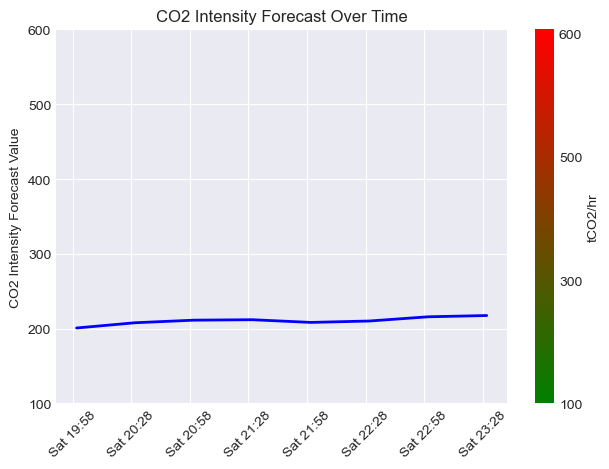

In [62]:
import matplotlib.colors as mcolors
import numpy as np 
import matplotlib.dates as mdates

plt.style.use('seaborn-darkgrid')  # Reapplying the style for consistency

# Correcting the colormap import
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_green_red", ["green", "red"]
)

norm = plt.Normalize(100, 600)

# Adjusting the DataFrame index for plotting (assuming 'EffectiveTime' should be the index)
# Creating the plot with corrected settings
fig, ax = plt.subplots()

# Increasing the width of the line with linewidth parameter
line = ax.plot(df.index, df['Value'], linewidth=2, color='blue')  # Using a solid color for simplicity

# Adjusting the x-axis to show every 30 minutes correctly
ax.xaxis_date()  # Ensure we're working with dates on the x-axis
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # Every 30 minutes
ax.xaxis.set_major_formatter(mdates.DateFormatter("%a %H:%M"))  # Day name and HH:MM

# Adding grid in the background
ax.grid(True)

# Adjusting colorbar to have ticks for every 200 values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", label="tCO2/hr")
cbar.set_ticks(np.arange(100, 600, 165))  # Adding ticks for every 200 values
cbar.set_ticklabels(["100", "300", "500", "600"])  # Custom labels for the colorbar

plt.xticks(rotation=45)
# plt.xlabel('Effective Time')
plt.ylabel('CO2 Intensity Forecast Value')
plt.title('CO2 Intensity Forecast Over Time')

# Customizing the axes to only show the left and bottom spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim([100, 600])

plt.tight_layout()
plt.show()

# Note regarding the x-axis labels showing times like 'Sat 19:58' instead of 'Sat 20:00':
# This might be due to the plotting library's handling of date-time ticks. 
# Ensuring the date-time objects are rounded to the nearest interval can help align the labels more accurately.


In [80]:
df['Value']=df['Value']*1.3

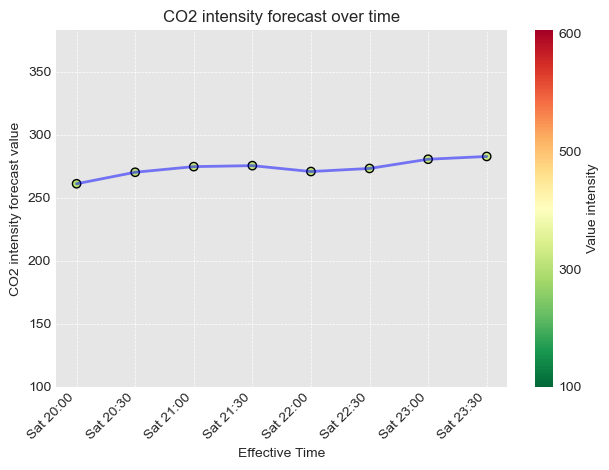

In [85]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Assuming 'df' is your DataFrame and already set up correctly
# First, ensure 'EffectiveTime' is the DataFrame's index and is of datetime type
df.index = pd.to_datetime(df.index)

# Setting up the colormap and norm for value intensity
norm = plt.Normalize(100, 600)
cmap = plt.get_cmap('RdYlGn_r')  # Using a built-in colormap that goes from green to red

# Creating the plot
fig, ax = plt.subplots()

# Plotting the line
ax.plot(df.index, df['Value'], color='b', alpha=0.5,linewidth=2)  # Line plot in grey for the trend

# Overlaying a scatter plot for value intensity
sc = ax.scatter(df.index, df['Value'], c=df['Value'], cmap=cmap, norm=norm, edgecolor='k')

# # Customizing the x-axis
# ax.xaxis_date()  # Working with dates on the x-axis
# # Manually setting x-axis ticks to be every 30 minutes, rounded
# tick_locator = mdates.MinuteLocator(interval=30)
# ax.xaxis.set_major_locator(tick_locator)
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%a %H:%M"))



# Ensure df.index is in the correct datetime format and set as the DataFrame's index
custom_ticks = df.index.to_series().dt.strftime("%a %H:%M")

# Set custom ticks and labels on the x-axis
ax.set_xticks(df.index)  # Set ticks at each index point
ax.set_xticklabels(custom_ticks, rotation=45, ha="right")  # Set custom formatted labels



# Customizing the colorbar
cbar = fig.colorbar(sc, ax=ax, orientation="vertical", label="Value intensity")
cbar.set_ticks(np.arange(100, 600, 165))  # Adding ticks for every 200 values
cbar.set_ticklabels(["100", "300", "500", "600"])  # Custom labels for the colorbar



# Adjusting plot appearance
ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adding a grid for readability
ax.set_ylim([100, df['Value'].max()+100])  # Setting y-axis limits
ax.set_xlabel('Effective Time')
ax.set_ylabel('CO2 intensity forecast value')
ax.set_title('CO2 intensity forecast over time')
# ax.spines['top'].set_visible(False)  # Hiding the top spine
# ax.spines['right'].set_visible(False)  # Hiding the right spine




plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [94]:
def find_optimized_relative_periods(df):
    # Normalize CO2 values to a 0-1 scale
    df['normalized'] = (df['Value'] - df['Value'].min()) / (df['Value'].max() - df['Value'].min())

    # Define thresholds for relative categorization
    low_threshold = df['normalized'].quantile(0.33)
    high_threshold = df['normalized'].quantile(0.66)

    # Categorize each timestamp
    df['category'] = pd.cut(df['normalized'], bins=[-np.inf, low_threshold, high_threshold, np.inf], labels=['Low', 'Medium', 'High'])

    # Find consecutive periods with the same category
    df['group'] = (df['category'] != df['category'].shift()).cumsum()

    # Prepare summary text
    summary_text = "Considering absolute CO2 emission values, distinct periods are identified as:\n\n"

    # Initialize a dictionary to store concatenated periods for each category
    period_summary = {'Low': [], 'Medium': [], 'High': []}

    # Group by category and group to concatenate periods
    for category, group in df.groupby(['category', 'group']):
        start_time = group.index.min().strftime('%H:%M')
        end_time = group.index.max().strftime('%H:%M')
        # For periods that start and end at the same time, just show one time
        period_str = f"{start_time} to {end_time}" if start_time != end_time else f"{start_time}"
        period_summary[category[0]].append(period_str)

    # Format the summary text for each category
    for category in ['Low', 'Medium', 'High']:
        if period_summary[category]:
            periods = ', '.join(period_summary[category])
            summary_text += f"{category} CO2 Emission Period: {periods}.\n"
        else:
            summary_text += f"{category} CO2 Emission Period: No specific periods identified.\n"

    return summary_text,df,period_summary

# Assuming df_ is your DataFrame with 'Value' column and DateTimeIndex
summary_text,df_test , period_summary= find_optimized_relative_periods(df_)
print(summary_text)


Considering absolute CO2 emission values, distinct periods are identified as:

Low CO2 Emission Period: 20:00 to 20:30, 22:00.
Medium CO2 Emission Period: 21:00, 22:30.
High CO2 Emission Period: 21:30, 23:00 to 23:30.



/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_2495/2481872867.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, group in df.groupby(['category', 'group']):


In [99]:
df_test.loc[:,['Value','category','normalized']]

,Value,category,normalized
EffectiveTime,,,
2024-02-17 20:00:00,200.9168,Low,0.000000
2024-02-17 20:30:00,207.9352,Low,0.421341
2024-02-17 21:00:00,211.3738,Medium,0.627773
2024-02-17 21:30:00,211.9682,High,0.663457
2024-02-17 22:00:00,208.3744,Low,0.447708
2024-02-17 22:30:00,210.2571,Medium,0.560733
2024-02-17 23:00:00,215.8810,High,0.898357
2024-02-17 23:30:00,217.5741,High,1.000000


In [106]:
df.normalized

EffectiveTime
2024-02-17 20:00:00    0.000000
2024-02-17 20:30:00    0.421341
2024-02-17 21:00:00    0.627773
2024-02-17 21:30:00    0.663457
2024-02-17 22:00:00    0.447708
2024-02-17 22:30:00    0.560733
2024-02-17 23:00:00    0.898357
2024-02-17 23:30:00    1.000000
Name: normalized, dtype: float64

In [126]:
today_date = datetime.datetime.now()
today_date.strftime("%A %d/%m/%Y")

'Saturday 17/02/2024'

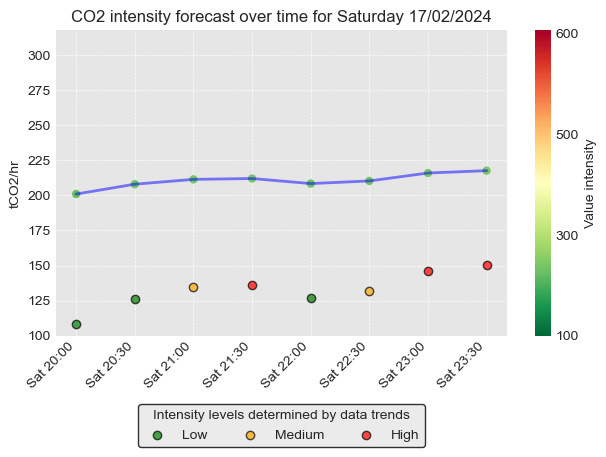

In [128]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

today_date = datetime.datetime.now()
today_date= today_date.strftime("%A %d/%m/%Y")
# First, ensure 'EffectiveTime' is the DataFrame's index and is of datetime type
df.index = pd.to_datetime(df.index)

# Setting up the colormap and norm for value intensity
norm = plt.Normalize(100, 600)
cmap = plt.get_cmap('RdYlGn_r')  # Using a built-in colormap that goes from green to red

# Creating the plot
fig, ax = plt.subplots()

# Plotting the line
ax.plot(df.index, df['Value'], color='b', alpha=0.5,linewidth=2)  # Line plot in grey for the trend

# Overlaying a scatter plot for value intensity
sc = ax.scatter(df.index, df['Value'], c=df['Value'], cmap=cmap, norm=norm, edgecolor='none')


# Ensure df.index is in the correct datetime format and set as the DataFrame's index
custom_ticks = df.index.to_series().dt.strftime("%a %H:%M")

# Set custom ticks and labels on the x-axis
ax.set_xticks(df.index)  # Set ticks at each index point
ax.set_xticklabels(custom_ticks, rotation=45, ha="right")  # Set custom formatted labels



# Customizing the colorbar
cbar = fig.colorbar(sc, ax=ax, orientation="vertical", label="Value intensity")
cbar.set_ticks(np.arange(100, 600, 165))  # Adding ticks for every 200 values
cbar.set_ticklabels(["100", "300", "500", "600"])  # Custom labels for the colorbar

# Creating a twin y-axis for normalized values
ax2 = ax.twinx()
ax2.set_yticks([])  # Removes the y-ticks
ax2.set_yticklabels([])  # Removes the y-tick labels

# Categorizing and coloring based on 'category'
colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
for category, color in colors.items():
    # Filter df for each category and plot on ax2 with specific color
    df_cat = df[df['category'] == category]
    ax2.scatter(df_cat.index, df_cat['normalized'], color=color, label=category, alpha=0.7, edgecolor='black')

ax2.set_ylim([-.2, 5])  # Setting y-axis limits
# Adjusting plot appearance
ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adding a grid for readability
ax.set_ylim([100, df['Value'].max()+100])  # Setting y-axis limits
ax.set_ylabel('tCO2/hr')
ax.set_title(f"CO2 intensity forecast over time for {today_date}")
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=True, edgecolor='black',
           title='Intensity levels determined by data trends')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


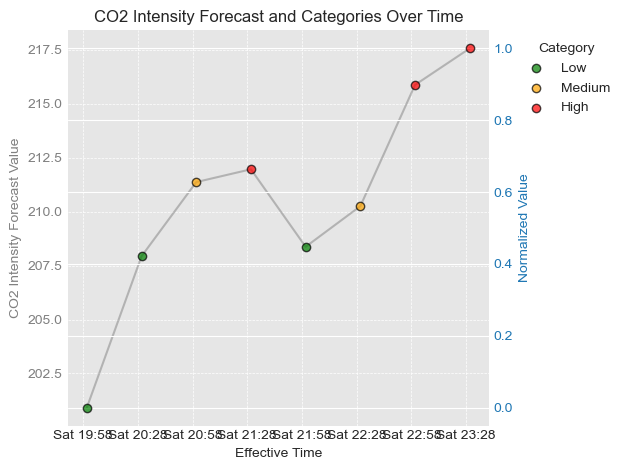

In [101]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Assuming 'df' is your DataFrame and is prepared as shown
df = df_test.copy()
# Setting up the plot
fig, ax1 = plt.subplots()

# Plotting the CO2 intensity values as a line plot on the primary y-axis
ax1.plot(df.index, df['Value'], color='grey', alpha=0.5, label='CO2 Intensity')

# Customize the primary y-axis
ax1.set_xlabel('Effective Time')
ax1.set_ylabel('CO2 Intensity Forecast Value', color='grey')
ax1.tick_params(axis='y', labelcolor='grey')

# Creating a twin y-axis for normalized values
ax2 = ax1.twinx()
ax2.set_ylabel('Normalized Value', color='tab:blue')  # Secondary y-axis label
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Categorizing and coloring based on 'category'
colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
for category, color in colors.items():
    # Filter df for each category and plot on ax2 with specific color
    df_cat = df[df['category'] == category]
    ax2.scatter(df_cat.index, df_cat['normalized'], color=color, label=category, alpha=0.7, edgecolor='black')

# Add legend for categories
ax2.legend(title='Category', loc='upper left', bbox_to_anchor=(1.05, 1))

# Customizing the x-axis to show formatted date and time
ax1.xaxis_date()
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%a %H:%M"))
plt.xticks(rotation=45)

# Title and grid
ax1.set_title('CO2 Intensity Forecast and Categories Over Time')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for readability
fig.tight_layout()

plt.show()


In [11]:
df_

,FieldName,Region,Value,status_compared_to_yesterday,status_compared_to_EU
EffectiveTime,,,,,
2024-02-17 20:00:00,CO2_INTENSITY_FORECAST,ALL,200.9168,medium,low
2024-02-17 20:30:00,CO2_INTENSITY_FORECAST,ALL,207.9352,medium,low
2024-02-17 21:00:00,CO2_INTENSITY_FORECAST,ALL,211.3738,medium,low
2024-02-17 21:30:00,CO2_INTENSITY_FORECAST,ALL,211.9682,medium,low
2024-02-17 22:00:00,CO2_INTENSITY_FORECAST,ALL,208.3744,medium,low
2024-02-17 22:30:00,CO2_INTENSITY_FORECAST,ALL,210.2571,medium,low
2024-02-17 23:00:00,CO2_INTENSITY_FORECAST,ALL,215.8810,medium,low
2024-02-17 23:30:00,CO2_INTENSITY_FORECAST,ALL,217.5741,medium,low


In [25]:
def create_message(forecast_start_date, co2_values):
    class Message:
        def __init__(self, system, user):
            self.system = system
            self.user = user

    co2_values_str = ', '.join(str(value) for value in co2_values)
    system_template = (
        f"The following data is about the forecasted CO2 emissions starting from {forecast_start_date} "
        f"until the end of today with a step of 30 minutes. Each value represents the CO2 intensity in grams per kWh. "
        f"Your task is to explain this information simply to the user, like a weather commentator. "
        f"\n\nCO2 values are: {co2_values_str}"
    )

    user_template = "When is the best and worst time to use energy today?"

    system = system_template
    user = user_template

    m = Message(system=system, user=user)
    return m

# Example usage
msg = create_message(
    forecast_start_date=str(df_.index[0]), co2_values=df_.Value.values
)

m = create_message(
    forecast_start_date="2024-02-08 22:00:00", co2_values=df_.Value.values
)

messages = [
    {"role": "system", "content": msg.system},
    {"role": "user", "content": msg.user},
]


messages = [
    {"role": "system", "content": m.system},
    {"role": "user", "content": m.user},
]

print(messages)


[{'role': 'system', 'content': 'The following data is about the forecasted CO2 emissions starting from 2024-02-08 22:00:00 until the end of today with a step of 30 minutes. Each value represents the CO2 intensity in grams per kWh. Your task is to explain this information simply to the user, like a weather commentator. \n\nCO2 values are: 198.4955, 203.3778, 216.6131, 218.7606, 219.6809, 219.1306'}, {'role': 'user', 'content': 'When is the best and worst time to use energy today?'}]


In [19]:
import openai
import os
import datetime
from datetime import timedelta


def create_message(forecast_start_date, co2_values,user_name):
    class Message:
        def __init__(self, system, user):
            self.system = system
            self.user = user

    start_datetime = datetime.datetime.strptime(forecast_start_date, "%Y-%m-%d %H:%M:%S")
    
    # Generate hours list based on the start_datetime and the length of co2_values
    hours = [(start_datetime + timedelta(minutes=30 * i)).strftime('%H:%M') for i in range(len(co2_values))]
    
    time_with_co2 = ", ".join(
        f"{hour} (CO2: {value} g/kWh)" for hour, value in zip(hours, co2_values)
    )

    # system_template = (
    #     f"Forecasted CO2 emissions data from {forecast_start_date}, updating every 30 minutes, is provided below. "
    #     f"Based on this, you are to give energy usage advice. Identify the most environmentally friendly hours "
    #     f"for energy consumption to minimize environmental impact, they are hours with the lowest values. Use the format: Most environmental friendly hours hh:mm, "
    #     f"hh:mm. Consider high CO2 > 500, low CO2 < 250, and medium for values in between and mention them if and only if any exists "
    #     f"\n\nCO2 values and corresponding times are: {time_with_co2}"
    #     f"\n\nProvide advice on the optimal time periods for energy consumption, do not need to give CO2 values to users."
    #     f"\n\n start with greeting user {user_name}, based on time {forecast_start_date}. Don't tell them they can ask questions. "
    # )
    system_template = (
            f"Hello {user_name}! Based on the forecasted CO2 emissions data from {forecast_start_date}, "
            "here is a summary of the energy consumption advice: \n\n"
            "Please identify the hours with the lowest CO2 values as the most environmentally friendly "
            "hours for energy consumption. Also, highlight any periods with high CO2 emissions that should be avoided. "
            "The aim is to provide a concise summary indicating the best and worst times for energy usage today, "
            "with a focus on minimizing environmental impact. \n\n"
            "The CO2 values and corresponding times are provided for your analysis. "
            "Generate a summary that categorizes the day into the lowest, medium, and highest CO2 emission periods, "
            "without suggesting further questions or interactions. \n\n"
            "CO2 values and times: {time_with_co2}"
        )

    user_template = "When are the best and worst time periods, on average, to use energy today from the environmental impact perspective in format of hour:minute?"

    system = system_template
    user = user_template

    m = Message(system=system, user=user)
    return m


def opt_gpt_summarise():
    # Ensure your API key is correctly set in your environment variables
    openai.api_key = os.getenv("OPENAI_API_KEY")

    # Construct the messages
    msg = create_message(
        forecast_start_date=str(df_.index[0]), co2_values=df_.Value.values,user_name = 'Saeed'
    )

    messages = [
        {"role": "system", "content": msg.system}
        # {"role": "user", "content": msg.user},
    ]

    try:
        # Making the API call
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",  # or "gpt-3.5-turbo" based on your subscription
            messages=messages,
            temperature= 1,
            max_tokens=600,  # Adjust the number of tokens as needed
            n=1,  # Number of completions to generate
            stop=None,  # Specify any stopping criteria if needed
        )

        # Extracting the response
        # generated_text = response.choices[0].message['content'].strip()
        generated_text = response.choices[0].message.content.strip()

        return generated_text
    except Exception as e:
        return str(e)


In [20]:
opt_gpt_summarise()

'Based on the forecasted CO2 emissions data for today, here is a summary of the energy consumption advice:\n\nLowest CO2 Emission Periods:\n1. 15:00 - 17:00: CO2 emissions are expected to be at their lowest during this time.\n2. 21:00 - 23:00: Another period with low CO2 emissions, making it an environmentally friendly choice for energy consumption.\n\nMedium CO2 Emission Periods:\n1. 11:00 - 13:00: Although not the lowest, CO2 emissions during this time are relatively moderate.\n\nHighest CO2 Emission Periods (to be avoided if possible):\n1. 07:00 - 09:00: CO2 emissions are expected to be at their highest during this time.\n2. 18:00 - 20:00: Another period with high CO2 emissions, indicating a potential peak in energy demand.\n\nBy aligning your energy consumption with the periods of lowest CO2 emissions, you can minimize your environmental impact. Avoiding energy usage during the highest CO2 emission periods can also help reduce your carbon footprint.'

In [23]:
df_

,FieldName,Region,Value,status_compared_to_yesterday,status_compared_to_EU
EffectiveTime,,,,,
2024-02-11 14:30:00,CO2_INTENSITY_FORECAST,ALL,217.0066,medium,low
2024-02-11 15:00:00,CO2_INTENSITY_FORECAST,ALL,223.2054,medium,low
2024-02-11 15:30:00,CO2_INTENSITY_FORECAST,ALL,225.9793,medium,low
2024-02-11 16:00:00,CO2_INTENSITY_FORECAST,ALL,225.6376,medium,low
2024-02-11 16:30:00,CO2_INTENSITY_FORECAST,ALL,228.8085,medium,low
2024-02-11 17:00:00,CO2_INTENSITY_FORECAST,ALL,226.1296,medium,low
2024-02-11 17:30:00,CO2_INTENSITY_FORECAST,ALL,229.3056,medium,low
2024-02-11 18:00:00,CO2_INTENSITY_FORECAST,ALL,223.1540,medium,low
2024-02-11 18:30:00,CO2_INTENSITY_FORECAST,ALL,225.4821,medium,low


In [86]:
import numpy as np 
def optimize_categorize_periods(df):
    # Define thresholds for CO2 emission categorization
    low_threshold, high_threshold = 250, 500

    # Categorize each timestamp
    df['category'] = pd.cut(df['Value'], bins=[-np.inf, low_threshold, high_threshold, np.inf], labels=['Low', 'Medium', 'High'])

    # Find consecutive periods with the same category
    df['group'] = (df['category'] != df['category'].shift()).cumsum()

    # Initialize summary text
    summary_text = "Based on the forecasted CO2 emissions data for today, distinct periods are identified as:\n\n"

    # Initialize a dictionary to store concatenated periods for each category
    period_summary = {'Low': [], 'Medium': [], 'High': []}

    # Group by category and group to concatenate periods
    for category, group in df.groupby(['category', 'group']):
        start_time = group.index.min().strftime('%H:%M')
        end_time = group.index.max().strftime('%H:%M')
        period_str = f"{start_time} to {end_time}" if start_time != end_time else f"{start_time}"
        period_summary[category[0]].append(period_str)

    # Format the summary text for each category
    for category in ['Low', 'Medium', 'High']:
        if period_summary[category]:
            periods = ', '.join(period_summary[category])
            summary_text += f"{category} CO2 Emission Periods: {periods}.\n"
        else:
            summary_text += f"{category} CO2 Emission Periods: No specific periods identified.\n"

    return summary_text

# Assuming df_ is your DataFrame with 'Value' column and DateTimeIndex
summary_text = optimize_categorize_periods(df_)
print(summary_text)


Based on the forecasted CO2 emissions data for today, distinct periods are identified as:

Low CO2 Emission Periods: 20:00 to 23:30.
Medium CO2 Emission Periods: No specific periods identified.
High CO2 Emission Periods: No specific periods identified.



/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_2495/449615099.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, group in df.groupby(['category', 'group']):


In [87]:
def find_optimized_relative_periods(df):
    # Normalize CO2 values to a 0-1 scale
    df['normalized'] = (df['Value'] - df['Value'].min()) / (df['Value'].max() - df['Value'].min())

    # Define thresholds for relative categorization
    low_threshold = df['normalized'].quantile(0.33)
    high_threshold = df['normalized'].quantile(0.66)

    # Categorize each timestamp
    df['category'] = pd.cut(df['normalized'], bins=[-np.inf, low_threshold, high_threshold, np.inf], labels=['Low', 'Medium', 'High'])

    # Find consecutive periods with the same category
    df['group'] = (df['category'] != df['category'].shift()).cumsum()

    # Prepare summary text
    summary_text = "Considering absolute CO2 emission values, distinct periods are identified as:\n\n"

    # Initialize a dictionary to store concatenated periods for each category
    period_summary = {'Low': [], 'Medium': [], 'High': []}

    # Group by category and group to concatenate periods
    for category, group in df.groupby(['category', 'group']):
        start_time = group.index.min().strftime('%H:%M')
        end_time = group.index.max().strftime('%H:%M')
        # For periods that start and end at the same time, just show one time
        period_str = f"{start_time} to {end_time}" if start_time != end_time else f"{start_time}"
        period_summary[category[0]].append(period_str)

    # Format the summary text for each category
    for category in ['Low', 'Medium', 'High']:
        if period_summary[category]:
            periods = ', '.join(period_summary[category])
            summary_text += f"{category} CO2 Emission Period: {periods}.\n"
        else:
            summary_text += f"{category} CO2 Emission Period: No specific periods identified.\n"

    return summary_text

# Assuming df_ is your DataFrame with 'Value' column and DateTimeIndex
summary_text = find_optimized_relative_periods(df_)
print(summary_text)


Considering absolute CO2 emission values, distinct periods are identified as:

Low CO2 Emission Period: 20:00 to 20:30, 22:00.
Medium CO2 Emission Period: 21:00, 22:30.
High CO2 Emission Period: 21:30, 23:00 to 23:30.



/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_2495/737246607.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, group in df.groupby(['category', 'group']):


In [64]:
def create_combined_gpt_prompt(date, eu_summary_text, quantile_summary_text):
    prompt = (
        f"Based on the forecasted CO2 emissions data for {date}, here are two analyses:\n\n"
        "1. **EU Standards Analysis**:\n"
        f"{eu_summary_text}\n\n"
        "2. ** Data Analysis**:\n"
        f"{quantile_summary_text}\n\n"
        "Given these detailed analyses, please provide advice on how to align energy consumption to minimize environmental impact, "
        "First start with an overview based on the EU standards. Then, considering both the broader EU standards and the more nuanced day-to-day variations.  "
        # "Highlight the optimal times for energy usage, especially focusing on the absolute lowest CO2 emission periods identified in the detailed analysis. "
        "The goal is to offer guidance that helps individuals effectively reduce their carbon footprint, "
        "using the insights from both the EU standards perspective and the data analysis. Make it short and cocise and give users time categories"
    )

    return prompt



# Assume 'eu_summary_text' is your summary based on EU standards
# 'quantile_summary_text' is the output from 'find_relative_periods' function
date = str(df_.index[0])
eu_summary_text = optimize_categorize_periods(df_)
quantile_summary_text = find_optimized_relative_periods(df_)  # Generate this based on your DataFrame

prompt = create_combined_gpt_prompt(date, eu_summary_text, quantile_summary_text)
print(prompt)


Based on the forecasted CO2 emissions data for 2024-02-11 14:30:00, here are two analyses:

1. **EU Standards Analysis**:
Based on the forecasted CO2 emissions data for today, distinct periods are identified as:

Low CO2 Emission Periods: 14:30 to 22:30.
Medium CO2 Emission Periods: No specific periods identified.
High CO2 Emission Periods: No specific periods identified.


2. ** Data Analysis**:
Considering absolute CO2 emission values, distinct periods are identified as:

Low CO2 Emission Period: 14:30 to 15:00, 18:00, 19:00 to 20:00.
Medium CO2 Emission Period: 15:30 to 16:00, 17:00, 18:30, 22:00.
High CO2 Emission Period: 16:30, 17:30, 20:30 to 21:30, 22:30.


Given these detailed analyses, please provide advice on how to align energy consumption to minimize environmental impact, First start with an overview based on the EU standards. Then, considering both the broader EU standards and the more nuanced day-to-day variations.  The goal is to offer guidance that helps individuals eff

/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_5562/449615099.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, group in df.groupby(['category', 'group']):
/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_5562/737246607.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, group in df.groupby(['category', 'group']):


In [65]:
import openai
import os
import datetime
from datetime import timedelta


def create_message(forecast_start_date, co2_values,user_name):
    class Message:
        def __init__(self, system, user):
            self.system = system
            self.user = user

    start_datetime = datetime.datetime.strptime(forecast_start_date, "%Y-%m-%d %H:%M:%S")
    
    # Generate hours list based on the start_datetime and the length of co2_values
    hours = [(start_datetime + timedelta(minutes=30 * i)).strftime('%H:%M') for i in range(len(co2_values))]
    
    time_with_co2 = ", ".join(
        f"{hour} (CO2: {value} g/kWh)" for hour, value in zip(hours, co2_values)
    )

    # system_template = (
    #     f"Forecasted CO2 emissions data from {forecast_start_date}, updating every 30 minutes, is provided below. "
    #     f"Based on this, you are to give energy usage advice. Identify the most environmentally friendly hours "
    #     f"for energy consumption to minimize environmental impact, they are hours with the lowest values. Use the format: Most environmental friendly hours hh:mm, "
    #     f"hh:mm. Consider high CO2 > 500, low CO2 < 250, and medium for values in between and mention them if and only if any exists "
    #     f"\n\nCO2 values and corresponding times are: {time_with_co2}"
    #     f"\n\nProvide advice on the optimal time periods for energy consumption, do not need to give CO2 values to users."
    #     f"\n\n start with greeting user {user_name}, based on time {forecast_start_date}. Don't tell them they can ask questions. "
    # )
    system_template = prompt

    user_template = "When are the best and worst time periods, on average, to use energy today from the environmental impact perspective in format of hour:minute?"

    system = system_template
    user = user_template

    m = Message(system=system, user=user)
    return m


def opt_gpt_summarise():
    # Ensure your API key is correctly set in your environment variables
    openai.api_key = os.getenv("OPENAI_API_KEY")

    # Construct the messages
    msg = create_message(
        forecast_start_date=str(df_.index[0]), co2_values=df_.Value.values,user_name = 'Saeed'
    )

    messages = [
        {"role": "system", "content": msg.system}
        # {"role": "user", "content": msg.user},
    ]

    try:
        # Making the API call
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",  # or "gpt-3.5-turbo" based on your subscription
            messages=messages,
            temperature= 1,
            max_tokens=600,  # Adjust the number of tokens as needed
            n=1,  # Number of completions to generate
            stop=None,  # Specify any stopping criteria if needed
        )

        # Extracting the response
        # generated_text = response.choices[0].message['content'].strip()
        generated_text = response.choices[0].message.content.strip()

        return generated_text
    except Exception as e:
        return str(e)


In [66]:
opt_gpt_summarise()

'Based on the EU standards, it is recommended to focus on minimizing energy consumption during the low CO2 emission periods from 14:30 to 22:30. Additionally, considering the more detailed data analysis, it is advisable to reduce energy usage during the following periods:\n\n1. Low CO2 Emission Periods:\n   - 14:30 to 15:00\n   - 18:00\n   - 19:00 to 20:00\n\n2. Medium CO2 Emission Periods:\n   - 15:30 to 16:00\n   - 17:00\n   - 18:30\n   - 22:00\n\n3. High CO2 Emission Periods:\n   - 16:30\n   - 17:30\n   - 20:30 to 21:30\n   - 22:30\n\nTo minimize your carbon footprint, prioritize energy-intensive activities outside of the high emission periods. This could include tasks such as laundry, running appliances, or charging electronics during low and medium emission periods. Additionally, adopting energy-efficient practices like using energy-saving light bulbs, properly insulating your home, and unplugging devices when not in use can further reduce environmental impact throughout the day.'